## Document Parsing


### Unstructured IO Parsing

In [ ]:
Lets start by parsing some documents using unstructured library

First we extract from the academic book of medicine the chapter that contains text, images and tables.

In [2]:
import os
from pathlib import Path

from pypdf import PdfReader, PdfWriter

# ---- inputs/outputs
ROOT = Path(os.getcwd()).resolve().parents[2]
PDF_PATH = ROOT / "data" / "raw" / "example.pdf"
SLICE_PATH = ROOT / "data" / "raw" / "endocrine_slice.pdf"
OUT_PATH = ROOT / "data" / "processed" / "example_p468_470.json"

START_PAGE, END_PAGE = 2922, 2925

# ---- slice PDF with PyPDF
reader = PdfReader(str(PDF_PATH))
writer = PdfWriter()
for p in range(START_PAGE - 1, END_PAGE):
    writer.add_page(reader.pages[p])
SLICE_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(SLICE_PATH, "wb") as f:
    writer.write(f)

In [ ]:
We apply the parser unstructured io to obtain the chunks of text, images and tables from the pdf.

In [3]:
from unstructured.partition.pdf import partition_pdf

chunks = partition_pdf(
    filename=SLICE_PATH,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=15000,
    combine_text_under_n_chars=300,
    
)

print(f"Extracted {len(chunks)} elements")


/home/alvar/anaconda3/envs/rag-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Extracted 6 elements


In [11]:
chunks[4].metadata

In [4]:
import unstructured

# --- Segregate the elements into different lists ---
texts = []
tables = []
images = []

for element in chunks:
    for orig_element in element.metadata.orig_elements:
        if isinstance(orig_element, unstructured.documents.elements.Table):
            tables.append(orig_element)
        elif isinstance(orig_element, unstructured.documents.elements.Image):
            images.append(orig_element)
        else:
            # This will catch Titles, NarrativeText, ListItems, etc.
            texts.append(element)

print(f"✅ Found {len(texts)} text elements.")
print(f"📊 Found {len(tables)} tables.")
print(f"🖼️ Found {len(images)} images.")

# Now you have your content neatly separated!
# You can inspect the first table's text content:
if tables:
    print("\n--- First Table Text ---")
    print(tables[0].text)

✅ Found 80 text elements.
📊 Found 3 tables.
🖼️ Found 7 images.

--- First Table Text ---
TABLE 376-1 Causes of Endocrine Dysfunction TYPE OF ENDOCRINE DISORDER EXAMPLES Hyperfunction Neoplastic Benign Pituitary adenomas, hyperparathyroidism, autonomous thyroid or adrenal nodules Malignant Adrenal cancer, medullary thyroid cancer, carcinoid Ectopic Ectopic ACTH, SIADH secretion Multiple endocrine neoplasia (MEN) MEN1, MEN2 Autoimmune Graves’ disease Iatrogenic Cushing’s syndrome, hypoglycemia Infectious/inflammatory Subacute thyroiditis Activating receptor mutations LH, TSH, Ca2+, PTH receptors, Gsα Hypofunction Autoimmune Hashimoto’s thyroiditis, type 1 diabetes mellitus, Addison’s disease, polyglandular failure Iatrogenic Radiation-induced hypopituitarism, hypothyroidism, surgical Infectious/inflammatory Adrenal insufficiency, hypothalamic sarcoidosis Hormone mutations GH, LHβ, FSHβ, vasopressin Enzyme defects 21-Hydroxylase deficiency Developmental defects Kallmann’s syndrome, Turner

╭────────────────────────────────────────────── Table 0 - HTML Structure ──────────────────────────────────────────────╮
│     1 <table>                                                                                                        │
│     2  <thead>                                                                                                       │
│     3   <tr>                                                                                                         │
│     4    <th>                                                                                                        │
│     5     TYPE OF ENDOCRINE DISORDER                                                                                 │
│     6    </th>                                                                                                       │
│     7    <th>                                                                                                        │
│     8     EXAMPLES                                                                                                   │
│     9    </th>                                                                                                       │
│    10   </tr>                                                                                                        │
│    11  </thead>                                                                                                      │
│    12  <tbody>                                                                                                       │
│    13   <tr>                                                                                                         │
│    14    <td colspan="2">                                                                                            │
│    15     Hyperfunction                                                                                              │
│    16    </td>                                                                                                       │
│    17   </tr>                                                                                                        │
│    18   <tr>                                                                                                         │
│    19    <td colspan="2">                                                                                            │
│    20     Neoplastic                                                                                                 │
│    21    </td>                                                                                                       │
│    22   </tr>                                                                                                        │
│    23   <tr>                                                                                                         │
│    24    <td>                                                                                                        │
│    25     Benign                                                                                                     │
│    26    </td>                                                                                                       │
│    27    <td>                                                                                                        │
│    28     Pituitary adenomas, hyperparathyroidism, autonomous thyroid or adrenal nodules                             │
│    29    </td>                                                                                                       │
│    30   </tr>                                                                                                        │
│    31   <tr>                                                                                                         │
│    32    <td>                                                                                                        │
│    33


📸 Displaying original image for Table 0:


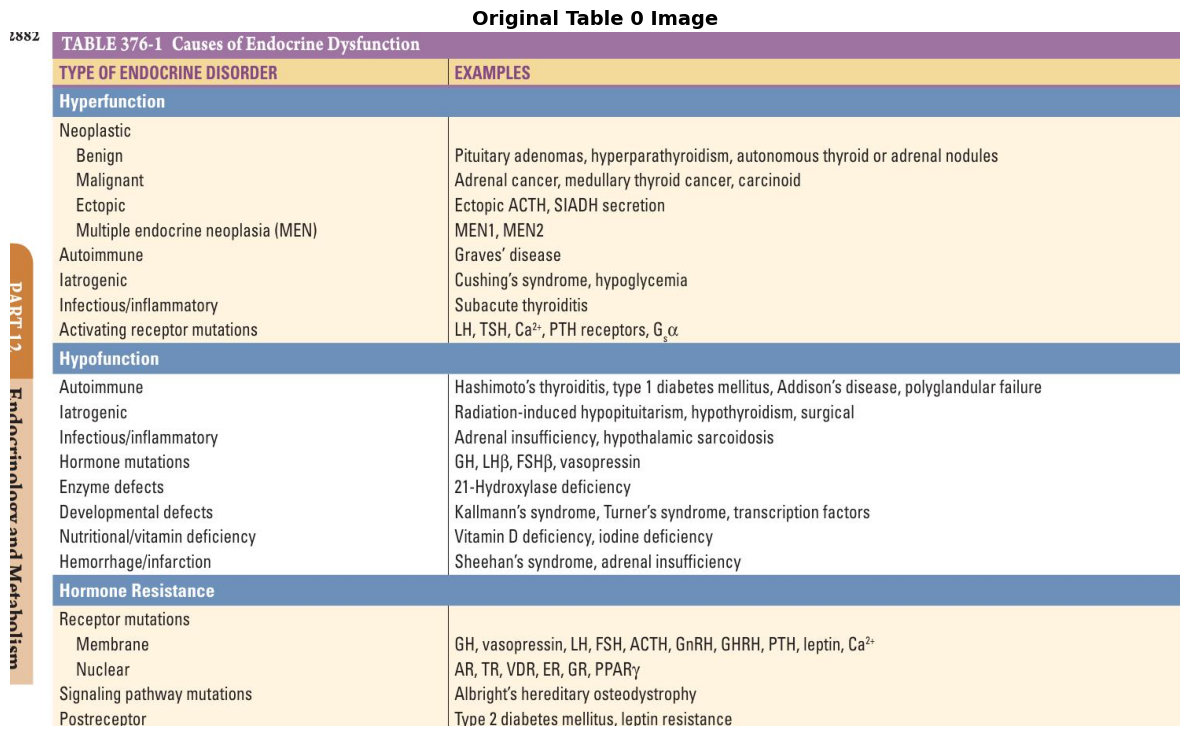

In [5]:
from rich.console import Console
from rich.syntax import Syntax
from rich.panel import Panel
from bs4 import BeautifulSoup
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

console = Console(width=120)  # Set console width

def display_html_formatted(html_content, title="HTML Content"):
    """Display HTML with proper formatting and line breaks"""
    
    # First, prettify the HTML to add proper line breaks
    soup = BeautifulSoup(html_content, 'html.parser')
    pretty_html = soup.prettify()
    
    # Create syntax-highlighted HTML with word wrapping
    syntax = Syntax(
        pretty_html, 
        "html", 
        theme="monokai", 
        line_numbers=True,
        word_wrap=True,
        code_width=100
    )
    
    # Display in a panel with proper width
    console.print(Panel(
        syntax, 
        title=title, 
        border_style="blue",
        width=120
    ))

def display_image_from_bytes(image_data, title="Original Image"):
    """Display image from base64 string or raw bytes data"""
    try:
        # Check if it's a base64 string and decode it
        if isinstance(image_data, str):
            image_bytes = base64.b64decode(image_data)
        else:
            image_bytes = image_data
            
        # Convert bytes to image
        image = Image.open(BytesIO(image_bytes))
        image.save("test.png")
        # Display using matplotlib
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')  # Hide axes
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error displaying image: {e}")

def display_table_and_image(table_index=0):
    """Display both HTML table structure and original image"""
    
    # Display HTML table structure
    if len(tables) > table_index and hasattr(tables[table_index].metadata, 'text_as_html'):
        html_content = tables[table_index].metadata.text_as_html
        display_html_formatted(html_content, f"Table {table_index} - HTML Structure")
        
        # Check if there's an associated image in image_base64
        if hasattr(tables[table_index].metadata, 'image_base64') and tables[table_index].metadata.image_base64:
            print(f"\n📸 Displaying original image for Table {table_index}:")
            display_image_from_bytes(
                tables[table_index].metadata.image_base64, 
                f"Original Table {table_index} Image"
            )
        else:
            print(f"\n❌ No image_base64 found in tables[{table_index}].metadata")
            # Show available attributes for debugging
            attrs = [attr for attr in dir(tables[table_index].metadata) if not attr.startswith('_')]
            print(f"Available metadata attributes: {attrs}")
    else:
        print(f"No HTML content found in tables[{table_index}].metadata.text_as_html")

# Execute the display function
display_table_and_image(0)

We can see that the html extraction of the tables is good but it can be better maybe using some visual LLM to extract the tables as images.

In [1]:
import ollama

# Path to the image file you saved in the previous cell
IMAGE_PATH = "test.png" 

# --- Enhanced Prompt ---
# This prompt asks the model to adopt a persona (data analyst), specifies the
# exact output format (JSON), and asks for an additional summary.
enhanced_prompt = """Analyze the text in the provided image. Extract all readable content
                                        and present it in a structured Markdown format that is clear, concise, 
                                        and well-organized. Ensure proper formatting (e.g., headings, lists, or
                                        code blocks) as necessary to represent the content effectively."""


print("🧠 Sending image and enhanced prompt to local vision model...")

try:
    # Call the Ollama API, passing the path to the image
    response = ollama.chat(
        model='llama3.2-vision:latest',  # Ensure you use a vision model you have pulled
        messages=[
            {
                'role': 'user',
                'content': enhanced_prompt,
                'images': [IMAGE_PATH]  # Pass the file path to the image
            }
        ]
    )

    # Extract and print the model's response
    model_output = response['message']['content']
    print("\n--- 🤖 Model Analysis ---")
    print(model_output)

except FileNotFoundError:
    print(f"❌ Error: The image file was not found at '{IMAGE_PATH}'. Please run the first cell to save it.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure your Ollama server is running and the model is pulled.")

🧠 Sending image and enhanced prompt to local vision model...

--- 🤖 Model Analysis ---
**Table 376-1: Causes of Endocrine Dysfunction**

**Types of Endocrine Dysfunction**

*   **Hyperfunction**
    *   Neoplastic
    *   Benign
    *   Malignant
    *   Ectopic
    *   Multiple endocrine neoplasia (MEN)
*   **Hypofunction**
    *   Autoimmune
    *   Iatrogenic
    *   Infectious/inflammatory
    *   Activating receptor mutations
*   **Hormone Resistance**
    *   Receptor mutations
    *   Membrane
    *   Nuclear
    *   Signaling pathway mutations
    *   Postreceptor

**Examples of Hyperfunction**

*   Pituitary adenomas, hyperparathyroidism, autonomous thyroid or adrenal nodules
*   Adrenal cancer, medullary thyroid cancer, carcinoid
*   Ectopic ACTH, SIADH secretion
*   MEN1, MEN2
*   Graves' disease
*   Cushing's syndrome, hypoglycemia
*   Subacute thyroiditis
*   LH, TSH, Ca2+, PTH receptors, Gα

**Examples of Hypofunction**

*   Hashimoto's thyroiditis, type 1 diabetes mellit

We can see that this type of models are not enough for this task but maybe if used other models like Gpt4o-mini or Gemini it could be a good solutions but you incurr in added expenses via API

In [57]:
chunks[0].metadata.orig_elements

Now lets try and apply for the table elements a parse directly from a photo of the table via llm or via a parser

### Camelot

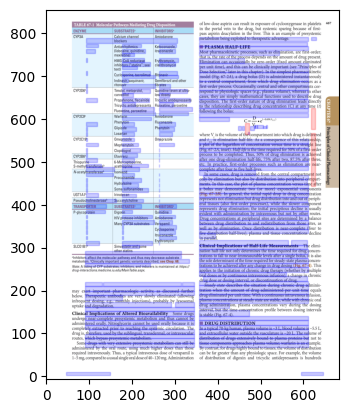

DataFrame created succesfully
                                             0  \
0                                                
1                                ENZYME\nCYP3A   
2                                      CYP2D6b   
3                                      CYP2C9b   
4                                     CYP2C19b   
5                                                
6   CYP2B6b\nThiopurine \nS-methyltransferaseb   
7                         N-acetyltransferaseb   
8                                      UGT1A1b   
9                        Pseudocholinesteraseb   
10                                 TRANSPORTER   
11     P-glycoprotein\n \n \n \n \n \nSLCO1B1b   
12                                               

                                                    1  \
0                                                       
1   TABLE 67-1  Molecular Pathways Mediating Drug ...   
2   Indinavir, saquinavir, \nritonavir\nTimolol, m...   
3   Fluoxetine, paroxetine\nWarfarin\nPhe

In [40]:
import camelot
import matplotlib.pyplot as plt
# Process the PDF
tables = camelot.read_pdf(SLICE_PATH, pages='all', flavor='lattice')

# Plot the first detected table
if tables:
    # 'kind' can be 'grid', 'text', 'contour', or 'joint'
    camelot.plot(tables[0], kind='text')
    # This will save a plot.png file in your directory
    plt.show()

    print("DataFrame created succesfully")

    print(tables[0].df)

In [38]:
markdown_table = tables[0].df.to_markdown(index=False)

print("\n--- RAG-Ready Markdown Table ---")
print(markdown_table)


--- RAG-Ready Markdown Table ---
| 0                                                                        | 1                                                                                  | 2                                   |
|:-------------------------------------------------------------------------|:-----------------------------------------------------------------------------------|:------------------------------------|
|                                                                          | of low-dose aspirin can result in exposure of cyclooxygenase in platelets          |                                     |
| TABLE 67-1  Molecular Pathways Mediating Drug Disposition                |                                                                                    |                                     |
|                                                                          | in  the  portal  vein  to  the  drug,  but  systemic  sparing  because  of  first- |     

As we can see the results are not good enough the structure is not preserved correctly

### LLM Table Parsing

For this study we are going to use the open-source model LlaVa

/home/alvar/CascadeProjects/windsurf-project/RAG


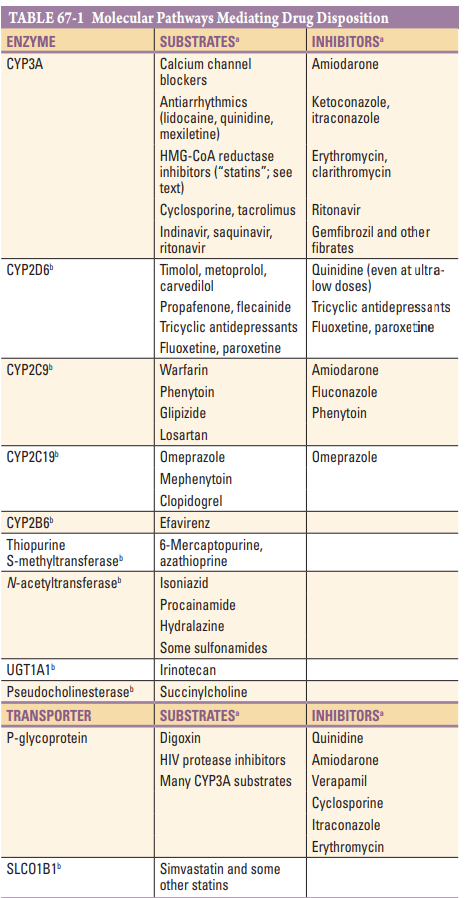

In [5]:
from IPython.display import Image, display
from pathlib import Path
import os
ROOT = Path(os.getcwd()).resolve().parents[2]

print(ROOT)
IMAGE_PATH = ROOT / 'src/simple_rag/parsers/utils/image.png'
  # Make sure this is the correct path to your image
display(Image(filename=IMAGE_PATH))

In [8]:
import ollama
import base64

def get_image_base64(image_path):
    """Converts an image file to a base64 encoded string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 1. Get the image in base64 format
image_base64 = get_image_base64(IMAGE_PATH)

# 2. Craft a specific prompt for table extraction in Markdown
prompt = """This is an image of a table. Transcribe the content of this table accurately.
Return the result as a structured JSON where each entry has the attributes as the columns"""

print("Sending image to local LLaVA model...")

# 3. Call the model and get the response
response = ollama.chat(
    model='gemma3:4b',
    messages=[
        {
            'role': 'user',
            'content': prompt,
            'images': [image_base64]
        }
    ]
)

# 4. Extract and print the parsed table
parsed_table_markdown = response['message']['content']
print("\n--- Parsed Table (Markdown) ---")
print(parsed_table_markdown)

Sending image to local LLaVA model...

--- Parsed Table (Markdown) ---
```json
[
  {
    "ENZYME": "CYP2C9",
    "SUBSTRATES": "Fluoxetine, paroxetine",
    "INHIBITORS": "Amidrone"
  },
  {
    "ENZYME": "CYP2C19",
    "SUBSTRATES": "Fluoxetine, paroxetine",
    "INHIBITORS": "Amidrone"
  },
  {
    "ENZYME": "CYP2C19",
    "SUBSTRATES": "Fluoxetine, paroxetine",
    "INHIBITORS": "Amidrone"
  },
  {
    "ENZYME": "CYP2C19",
    "SUBSTRATES": "Fluoxetine, paroxetine",
    "INHIBITORS": "Amidrone"
  },
  {
    "ENZYME": "CYP2C19",
    "SUBSTRATES": "Fluoxetine, paroxetine",
    "INHIBITORS": "Amidrone"
  },
  {
    "ENZYME": "UGT1A1",
    "SUBSTRATES": "Pseudocholine",
    "INHIBITORS": "Quindrone"
  },
  {
    "ENZYME": "SLCO1B1",
    "SUBSTRATES": "Digoxin",
    "INHIBITORS": "Quindrone"
  }
]
```


We can see that the LlaVA model is not working properly, lets try now with the LLama-Vision Model

In [ ]:
import ollama
import base64

def get_image_base64(image_path):
    """Converts an image file to a base64 encoded string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


IMAGE_PATH = "./utils/image.png"
# 1. Get the image in base64 format
image_base64 = get_image_base64(IMAGE_PATH)

# 2. Craft a specific prompt for table extraction in Markdown
prompt = """
[SYSTEM]
You are a precision data extraction engine. Your task is to analyze the provided image of a table and convert it into a structured, valid JSON array of objects. Adhere strictly to the rules below.

[TASK DEFINITION]
1.  **Identify Headers**: Detect the column headers from the top row of the table.
2.  **Parse Rows**: Transcribe each subsequent row of data.
3.  **Construct JSON**: Create a JSON object for each row where the keys are the sanitized column headers and the values are the cell data.

[OUTPUT FORMATTING & RULES]
1.  **JSON Structure**: The final output MUST be a single JSON array `[...]`. Each element in the array must be a JSON object `{...}` representing one row.
2.  **Header Sanitization**: Convert all column headers to `snake_case` for use as JSON keys. For example, "Product Name" becomes "product_name" and "SKU #" becomes "sku_hash".
3.  **Data Typing**: Infer data types automatically. Numbers (e.g., 1, 45.6) should be JSON numbers, not strings. Booleans should be `true` or `false`.
4.  **Empty Cells**: If a cell is empty or contains only whitespace, its value in the JSON must be `null`.
5.  **Merged Cells**: If a cell in one column spans multiple rows, duplicate its value across all corresponding row objects in the JSON.
6.  **Illegible Data**: If a cell's content is ambiguous or cannot be read, use the string "DATA_UNCLEAR" as its value.
7.  **Strictness**: Your entire response must be ONLY the JSON data. Do not include any introductory text, explanations, summaries, or markdown code fences like ```json. The response must start with `[` and end with `]`.

[EXAMPLE]
For a table with headers "Item ID", "In Stock", "Price" and a row containing "A-102", "Yes", "29.99", the corresponding JSON object would be:
{
  "item_id": "A-102",
  "in_stock": true,
  "price": 29.99
}
"""

print("Sending image to local Llama3.2-Vision model...")

# 3. Call the model and get the response
response = ollama.chat(
    model='llama3.2-vision:11b-instruct-q4_K_M',
    messages=[
        {
            'role': 'user',
            'content': prompt,
            'images': [image_base64]
        }
    ]
)

# 4. Extract and print the parsed table
parsed_table_markdown = response['message']['content']
print("\n--- Parsed Table (Markdown) ---")
print(parsed_table_markdown)

Sending image to local LLaVA model...

--- Parsed Table (Markdown) ---
[...]
[
  {
    "enzyme": "CYP3A",
    "substrates": [
      "Calcium channel blockers",
      "Antiarrhythmics (lidocaine, quinidine, mexiletine)",
      "HMG-CoA reductase inhibitors ('statins', see text)",
      "Cyclosporine, tacrolimus",
      "Indinavir, saquinavir"
    ],
    "inhibitors": [
      "Amiodarone",
      "Ketoconazole, itraconazole"
    ],
    "transporter": "P-glycoprotein"
  },
  {
    "enzyme": "CYP2D6",
    "substrates": [
      "Timolol, metoprolol, carvedilol",
      "Propafenone, flecanide",
      "Tricyclic antidepressants",
      "Fluoxetine, paroxetine"
    ],
    "inhibitors": [
      "Quinidine (even at ultra-low doses)",
      "Tricyclic antidepressants"
    ],
    "transporter": "P-glycoprotein"
  },
  {
    "enzyme": "CYP2C9",
    "substrates": [
      "Warfarin",
      "Phenitocin",
      "Fluconazol"
    ],
    "inhibitors": [
      "Amiodarone",
      "Fluconazol"
    ],
    "tr

Lastly, lets try the Qwen 2.5 7b Vision model

In [38]:
import ollama
import base64

def get_image_base64(image_path):
    """Converts an image file to a base64 encoded string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


IMAGE_PATH = "./utils/image.png"
# 1. Get the image in base64 format
image_base64 = get_image_base64(IMAGE_PATH)

# 2. Craft a specific prompt for table extraction in Markdown
prompt = """
[SYSTEM]
You are a precision data extraction engine. Your task is to analyze the provided image of a table and convert it into a structured, valid JSON array of objects. Adhere strictly to the rules below.

[TASK DEFINITION]
1.  **Identify Headers**: Detect the column headers from the top row of the table.
2.  **Parse Rows**: Transcribe each subsequent row of data.
3.  **Construct JSON**: Create a JSON object for each row where the keys are the sanitized column headers and the values are the cell data.

[OUTPUT FORMATTING & RULES]
1.  **JSON Structure**: The final output MUST be a single JSON array `[...]`. Each element in the array must be a JSON object `{...}` representing one row.
2.  **Header Sanitization**: Convert all column headers to `snake_case` for use as JSON keys. For example, "Product Name" becomes "product_name" and "SKU #" becomes "sku_hash".
3.  **Data Typing**: Infer data types automatically. Numbers (e.g., 1, 45.6) should be JSON numbers, not strings. Booleans should be `true` or `false`.
4.  **Empty Cells**: If a cell is empty or contains only whitespace, its value in the JSON must be `null`.
5.  **Merged Cells**: If a cell in one column spans multiple rows, duplicate its value across all corresponding row objects in the JSON.
6.  **Illegible Data**: If a cell's content is ambiguous or cannot be read, use the string "DATA_UNCLEAR" as its value.
7.  **Strictness**: Your entire response must be ONLY the JSON data. Do not include any introductory text, explanations, summaries, or markdown code fences like ```json. The response must start with `[` and end with `]`.

[EXAMPLE]
For a table with headers "Item ID", "In Stock", "Price" and a row containing "A-102", "Yes", "29.99", the corresponding JSON object would be:
{
  "item_id": "A-102",
  "in_stock": true,
  "price": 29.99
}
"""

print("Sending image to local Qwen2.5-Vision model...")

# 3. Call the model and get the response
response = ollama.chat(
    model='qwen2.5vl:7b',
    messages=[
        {
            'role': 'user',
            'content': prompt,
            'images': [image_base64]
        }
    ]
)

# 4. Extract and print the parsed table
parsed_table_markdown = response['message']['content']
print("\n--- Parsed Table (Markdown) ---")
print(parsed_table_markdown)

Sending image to local Llama3.2-Vision model...


KeyboardInterrupt: 

Analyzing the results with the current Hardware that is available which is a 8gb Ram 4070 GPU for some tables it is not enough and would be better to call some more advanced models via API like DeepSeek or Gemini.

## OCR + Unstrucured

Now the Unstructured run after the OCR has parsed the scanned PDF

In [2]:
from unstructured.partition.pdf import partition_pdf
import os
import json

SLICE_PATH = ROOT / "data" / "raw" / "attention.pdf"
OUT_PATH = ROOT / "data" / "processed" / "attention.json"

# parse only page 508

file_path = "attention.pdf"

chunks = partition_pdf(
    filename=SLICE_PATH,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
)




/home/alvar/CascadeProjects/windsurf-project/RAG/.rag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [13]:
chunks[5].metadata.orig_elements

In [ ]:
for chunk in chunks:
    


In [17]:
from pypdf import PdfReader



OUT_PATH = ROOT / "data" / "processed" / "example_p468_470.json"


reader = PdfReader(str(SLICE_PATH))
n_pages = len(reader.pages)
print("Pages in PDF:", n_pages)

def page_has_text_layer(reader, page_no_1based: int) -> bool:
    try:
        page = reader.pages[page_no_1based - 1]
        txt = page.extract_text() or ""
        return bool(txt.strip())
    except Exception:
        return False

for p in range(1, n_pages + 1):   # page numbers are 1-based
    print(f"Page {p} has text layer:", page_has_text_layer(reader, p))


Pages in PDF: 3
Page 1 has text layer: True
Page 2 has text layer: True
Page 3 has text layer: True


In [37]:

from IPython.display import Markdown, display

display(Markdown(str(chunks[0].text)))
print(chunks[1])

TABLE 67-1 Molecular Pathways Mediating Drug Disposition

ENZYME SUBSTRATESa INHIBITORSa CYP3A Calcium channel Amiodarone blockers Antiarrhythmics Ketoconazole, (lidocaine, quinidine, itraconazole mexiletine) HMG-CoA reductase Erythromycin, inhibitors (“statins”; see clarithromycin text) Cyclosporine, tacrolimus Ritonavir Indinavir, saquinavir, Gemfibrozil and other ritonavir fibrates CYP2D6b Timolol, metoprolol, Quinidine (even at ultra- carvedilol low doses) Propafenone, flecainide Tricyclic antidepressants Tricyclic antidepressants Fluoxetine, paroxetine Fluoxetine, paroxetine CYP2C9b Warfarin Amiodarone Phenytoin Fluconazole Glipizide Phenytoin Losartan CYP2C19b Omeprazole Omeprazole Mephenytoin Clopidogrel CYP2B6b Efavirenz Thiopurine 6-Mercaptopurine, S-methyltransferaseb azathioprine N-acetyltransferaseb Isoniazid Procainamide Hydralazine Some sulfonamides UGT1A1b Irinotecan Pseudocholinesteraseb Succinylcholine TRANSPORTER SUBSTRATESa INHIBITORSa P-glycoprotein Digoxin Quinidine HIV protease inhibitors Amiodarone Many CYP3A substrates Verapamil Cyclosporine Itraconazole Erythromycin SLCO1B1b Simvastatin and some

other statins

aInhibitors affect the molecular pathway and thus may decrease substrate metabolism. bClinically important genetic variants described; see Chap. 68.

Note: A listing of CYP substrates, inhibitors, and inducers is maintained at https:// drug-interactions.medicine.iu.edu/MainTable.aspx.

may exert important pharmacologic activity, as discussed further below. Therapeutic antibodies are very slowly eliminated (allowing infrequent dosing, e.g., monthly injections), probably by lysosomal uptake and degradation.

Clinical Implications of Altered Bioavailability Some drugs undergo near-complete presystemic metabolism and thus cannot be administered orally. Nitroglycerin cannot be used orally because it is completely extracted prior to reaching the systemic circulation. The drug is, therefore, used by the sublingual, transdermal, or intravascular routes, which bypass presystemic metabolism.

Some drugs with very extensive presystemic metabolism can still be administered by the oral route, using much higher doses than those required intravenously. Thus, a typical intravenous dose of verapamil is 1–5 mg, compared to a usual single oral dose of 40–120 mg. Administration

HPIM21e_Part3_p465-p480.indd 467

of low-dose aspirin can result in exposure of cyclooxygenase in platelets in the portal vein to the drug, but systemic sparing because of first- pass aspirin deacylation in the liver. This is an example of presystemic metabolism being exploited to therapeutic advantage.

467

■ PLASMA HALF-LIFE

Most pharmacokinetic processes, such as elimination, are first-order; that is, the rate of the process depends on the amount of drug present. Elimination can occasionally be zero-order (fixed amount eliminated per unit time), and this can be clinically important (see “Principles of Dose Selection,” later in this chapter). In the simplest pharmacokinetic model (Fig. 67-2A), a drug bolus (D) is administered instantaneously to a central compartment, from which drug elimination occurs as a first-order process. Occasionally, central and other compartments cor- respond to physiologic spaces (e.g., plasma volume), whereas in other cases, they are simply mathematical functions used to describe drug disposition. The first-order nature of drug elimination leads directly to the relationship describing drug concentration (C) at any time (t) following the bolus:

C = D V •e − ( 0.69t/t 1/2 )

c

C

L9 YA LdVHO

H

A

P

T

E

R

6

7

P

r

i

where Vc is the volume of the compa

In [36]:
chunks[0].metadata.orig_elements

## LLamaParse

In [32]:
import os
from pathlib import Path
from dotenv import load_dotenv
from pypdf import PdfReader, PdfWriter
from llama_parse import LlamaParse

# ---- load environment variables from .env
load_dotenv()
api_key = os.getenv("LLAMAPARSE_API_KEY")
if not api_key:
    raise RuntimeError("LLAMAPARSE_API_KEY not set in .env")

# ---- inputs/outputs
ROOT = Path(os.getcwd()).resolve().parents[2]
PDF_PATH = "../../data/raw/uni/learning_big_data.pdf"
OUT_PATH = ROOT / "data" / "processed" / "big_data.md"


SLICE_PATH = ROOT / "data" / "raw" / "uni" / "learning_guide_big_data.pdf"


instruction = ("Preserve the document structure and content maintaining, mathematical equations \n"
               "Pay special attention also to the table structure and content so that it matches the original one (headers included)")

parser = LlamaParse(
    api_key=api_key,
    result_type="markdown",
    language="en",
    num_workers=4,
    parsing_instruction = instruction

   
) 

In [33]:
try:
    print("[llamaparse] sending slice…")
    docs = parser.load_data(str(SLICE_PATH))
    print("[llamaparse] returned docs:", len(docs))
except Exception as e:
    print("[llamaparse] exception:", repr(e))
    raise

# If nothing came back, print more breadcrumbs
if len(docs) == 0:
    print("[warn] LlamaParse returned 0 docs. Quick checklist:")
    print("  - Is the file really text/scan? Try a different page range.")
    print("  - Try result_type='text' or 'structured'.")
    print("  - Try without slicing: pass the full PDF once.")
    print("  - Check network/proxy; Llama Cloud needs outbound https.")
    print("  - Double-check key validity (a bad key can yield empty results).")

# ------

[llamaparse] sending slice…
Started parsing the file under job_id 247a1351-aec7-40f2-b7e9-009f94f9b476
[llamaparse] returned docs: 13


In [34]:
from pathlib import Path
import re, html

SINGLE_MD = Path(OUT_PATH)

HEADING_RE = re.compile(r"(?m)^(#{1,6})(\S)")                     # ensure '#Title' -> '# Title'
TABLE_ROW_RE = re.compile(r"^\s*\|")                               # lines that look like pipe-table rows
TABLE_SEP_RE = re.compile(r"^\s*\|?\s*:?-{2,}:?\s*(\|\s*:?-{2,}:?\s*)+\|?\s*$")

def normalize_markdown(md: str) -> str:
    if not md:
        return ""
    # 1) decode HTML entities (&#x3C; -> <)
    md = html.unescape(md)

    # 2) fix headings missing a space: '#Title' -> '# Title'
    md = HEADING_RE.sub(lambda m: f"{m.group(1)} {m.group(2)}", md)

    # 3) collapse >2 blank lines to max 2
    md = re.sub(r"\n{3,}", "\n\n", md)

    # 4) ensure a blank line BEFORE headings
    md = re.sub(r"(?m)([^\n])\n(#{1,6}\s)", r"\1\n\n\2", md)

    # 5) ensure a blank line AFTER headings (if next line is not blank)
    md = re.sub(r"(?m)^(#{1,6}\s.+)\n(?!\n|\||-{3,})", r"\1\n\n", md)

    # 6) ensure blank lines around tables (pipe-style)
    lines = md.splitlines()
    out = []
    for i, line in enumerate(lines):
        # insert blank line before a table row if previous non-empty line isn't blank or header
        if TABLE_ROW_RE.match(line):
            if out and out[-1].strip() and not TABLE_ROW_RE.match(out[-1]) and not TABLE_SEP_RE.match(out[-1]):
                out.append("")  # blank line before table
        out.append(line)
        # if this is a table separator row, ensure there's at least one row above & below (renderer-friendly)
        # (we won’t synthesize; just spacing)
        if TABLE_SEP_RE.match(line):
            # ensure there is a blank line after the table end (will be added when next non-table appears)
            pass
    md = "\n".join(out)

    # 7) demote standalone page banners like "# 468" to smaller heading or italic line
    md = re.sub(r"(?m)^#\s+(\d{1,5})\s*$", r"### Page \1", md)

    # 8) strip stray trailing spaces
    md = re.sub(r"[ \t]+(\n)", r"\1", md)

    return md.strip() + "\n"

def safe_anchor(s: str) -> str:
    s = re.sub(r"[^\w\s-]", "", s).strip().lower()
    s = re.sub(r"\s+", "-", s)
    return s[:80] or "chunk"

toc = ["# Parsed Output", "## Table of Contents"]
parts = []

for i, d in enumerate(docs):
    raw = (getattr(d, "text", "") or "").strip()
    if not raw:
        continue
    md = normalize_markdown(raw)

    # build a visible section header so chunk boundaries are obvious
    meta = dict(getattr(d, "metadata", {}) or {})
    page = meta.get("page_number") or meta.get("page") or "n/a"
    # use first heading in the chunk as title, else "Chunk i"
    m = re.search(r"(?m)^\s*#{1,6}\s+(.+)$", md)
    title = m.group(1).strip() if m else f"Chunk {i}"
    anchor = f"chunk-{i}-{safe_anchor(title)}"

    toc.append(f"- [Chunk {i} — p. {page}: {title}](#{anchor})")
    parts.append(
        f"\n\n---\n\n<a id='{anchor}'></a>\n\n## Chunk {i} — Page {page}\n\n{md}"
    )

final_md = "\n".join(toc) + "\n" + "".join(parts)
SINGLE_MD.parent.mkdir(parents=True, exist_ok=True)
SINGLE_MD.write_text(final_md, encoding="utf-8")
print(f"Saved single markdown → {SINGLE_MD}")

Saved single markdown → /home/alvar/CascadeProjects/windsurf-project/RAG/data/processed/big_data.md
